# Test for data leakage
The dataset contains embeddings from pictures obtained after treating cells in culture with various compounds. The experiments were performed in micro well plates, each well was treated with one compound, and four pictures of each well were taken. Compounds have different modes of action (MoA), and we aim at training classifier to identify the MoA from the picture embeddings. However, the train/test split should ensure a single compound does not end up both in the training and in the test set. Besides, several pictures of the same well should also be in a single set. Failure to do so will likely result in data leakage.
The objective of this notebook is to ensure the splitting of the test and train sets (done in another notebook) did not result in data leakage. To test this, we will train a decision tree to the full length on the train set. By definition, decision trees always overfit the training set if not restrained. We therefore expect this classifier to have a poor accuracy on the test set. 

In [180]:
#import packages
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

PCA with whitening was performed on the embeddings dataset to reduce noise, and reduce the number of features from more than 3000 to the 256 first principal components. Remark: PCA was tested with 32, 64, 128 and 256 PCs, but only the 256 PCs covered 95% of the original dataset variance. This is why we chose to continue with 256 PCs.

In [191]:
#we load the dataset 
df = pd.read_csv('df_256pc.csv')

#we load the dataset containing the train/test splitting information per compound
df_train_test = pd.read_csv('compound_moas_trainVtest.csv')


df.head()

C:\Users\gillefl1\AppData\Local\Temp\1\ipykernel_10888\1682652756.py:2: DtypeWarning: Columns (264) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_256pc.csv')


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,255,Metadata_PlateNumber,Metadata_ID,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Replicate,Metadata_Compound,Metadata_Concentration,Metadata_SMILES,Metadata_MoA
0,0,1.529221,-0.951013,-0.418567,-0.139094,0.261078,0.054629,0.317348,-1.172805,-0.140829,...,-1.359518,27481,4_233,4,233,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown
1,1,2.593105,-0.304439,-1.062823,-0.080481,0.766087,-0.210951,-0.419353,-0.221305,-0.825691,...,0.026206,27481,4_234,4,234,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown
2,2,1.414365,-1.195031,-0.212604,0.928105,-0.475267,-0.171795,0.056980,-0.895743,-0.141581,...,-0.919839,27481,4_235,4,235,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown
3,3,1.589802,-0.402039,-0.473486,0.843948,-0.107002,-0.435631,-0.859494,-0.376768,0.383684,...,-1.332179,27481,4_236,4,236,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown
4,4,3.312258,-0.850536,-1.024865,-0.063679,0.956594,-0.339282,-0.931775,-1.323054,-1.410435,...,1.301231,27521,4_473,4,473,2,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown


In [192]:
#now we add a column in the dataset with info on whether each row belongs to the test or to the train set
df = df.merge(df_train_test[['Compound','in_testset']], left_on = 'Metadata_Compound', right_on = 'Compound')

#we remove the DMSO lines (negative control) because this compound is a negative control, and is overrepresented in the dataset
df = df[df.Metadata_Compound != 'DMSO']


df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,Metadata_ID,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Replicate,Metadata_Compound,Metadata_Concentration,Metadata_SMILES,Metadata_MoA,Compound,in_testset
0,384,0.179174,-1.333567,0.201975,-0.956108,-0.483485,0.608033,1.097710,0.030762,-0.299468,...,2_113,2,113,1,ALLN,0.03,CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC...,Protein degradation,ALLN,False
1,385,-0.027667,-0.600343,0.954132,-1.454483,0.086165,0.383087,0.275815,1.274526,-0.273789,...,2_114,2,114,1,ALLN,0.03,CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC...,Protein degradation,ALLN,False
2,386,1.162443,0.063443,1.443530,-0.737389,-0.401925,-0.230893,-1.630222,1.073171,-0.752724,...,2_115,2,115,1,ALLN,0.03,CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC...,Protein degradation,ALLN,False
3,387,0.821926,0.226972,2.328007,0.704615,0.306736,0.046971,-0.620694,0.815463,-1.959834,...,2_116,2,116,1,ALLN,0.03,CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC...,Protein degradation,ALLN,False
4,388,-0.018359,-0.891648,-0.427397,0.140324,-0.379426,-0.341836,-0.276706,-0.782538,0.556125,...,2_353,2,353,2,ALLN,0.03,CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC...,Protein degradation,ALLN,False


In [193]:
#let's filter the dataframe to only keep the principal components and the MoA
columns_keep = list(df.columns[1:257])
columns_keep.append('Metadata_MoA')
columns_keep.append('in_testset')
df_filtered = df[columns_keep]

#now, let's do the actual train/test slit
df_train = df_filtered[~df_filtered.in_testset].iloc[:, :-1]
df_test = df_filtered[df_filtered.in_testset].iloc[:, :-1]


Let's now check for the class balance in the training set

In [194]:
print('training set class balance:\n')
print(df_train.groupby('Metadata_MoA')['0'].count())


training set class balance:

Metadata_MoA
Actin disruptors             192
Aurora kinase inhibitors     192
Cholesterol-lowering         192
DNA damage                   288
DNA replication              288
Eg5 inhibitors               192
Epithelial                   192
Kinase inhibitors            128
Microtubule destabilizers    288
Microtubule stabilizers      192
Protein degradation          288
Protein synthesis            192
Name: 0, dtype: int64


The classes are more or less balanced in the training set. 

In [195]:
#split X and y
X_train = df_train.iloc[:, :-1].values
y_train = df_train['Metadata_MoA'].values.reshape(-1, 1)

X_test = df_test.iloc[:, :-1].values
y_test = df_test['Metadata_MoA'].values.reshape(-1, 1)

#one hot encode categorical variables of y
enc = OneHotEncoder(sparse_output=False)
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)


Let's now train the decision tree

Accuracy score on the test set: 0.42824909747292417
Accuracy score on the train set: 1.0


<AxesSubplot:>

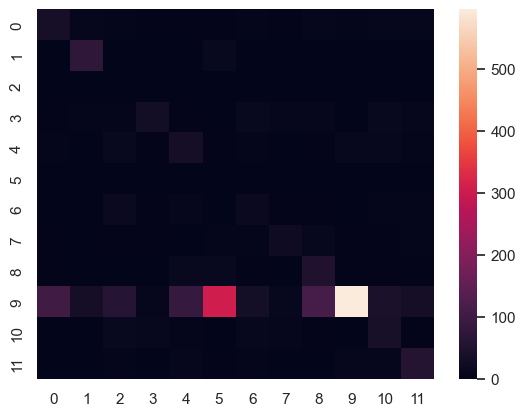

In [196]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

print('Accuracy score on the test set: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score on the train set: {}'.format(accuracy_score(y_train, y_pred_train)))

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

sns.heatmap(cm)

We have an accuracy score of 100% on the training set, and 43% on the test set, which indicates that the model is clearly overfitting the training set. 
We can also see on the confusion matrix that the model is pretty bad in predicting most of the classes, except for class 9 that seems to be quite well predicted even by the overfit classifier. 

If we had data leakage, we would expect a better performance on most classes. The good prediction of class 9 which seems to be responsible for the relatively high accuracy score (43%) given the number of classes, does not seem to be a result of data leakage, but rather obtained "out of luck".  The train/test split of the data therefore seems to be suitable.
Still, let's compare the confusion matrix with the one of a dummy classifier

Accuracy score on the test set: 0.03023465703971119


<AxesSubplot:>

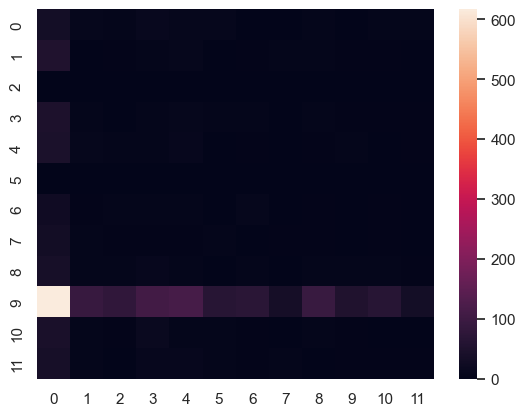

In [199]:
dummy = DummyClassifier(random_state=0, strategy = 'stratified')
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)


print('Accuracy score on the test set: {}'.format(accuracy_score(y_test, y_pred)))

cm=confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))

sns.heatmap(cm)

We can see that apart from class 9, all classes are equally badly predicted by the dummy classifier and the overfit decision tree classifier. It confirms that we do not seem to have data leakage caused by our train/test split.